In [3]:
import numpy as np
import scipy.misc
import pylab
import torch
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
from wavelets_pytorch_2.alltorch.wavelets import Morlet, Ricker, DOG, Paul
from wavelets_pytorch_2.alltorch.transform import WaveletTransformTorch #WaveletTransform, 
import torch.utils.data as data_utils
from IPython.display import clear_output
from tqdm import tqdm_notebook,tqdm
from sklearn.preprocessing import normalize
import matplotlib.image as mpimg
import time
import wfdb as wf


# from wavelets_pytorch_2.backup_pytorchwavelets.wavelets import Morlet, Ricker, DOG
# from wavelets_pytorch_2.backup_pytorchwavelets.transform import WaveletTransformTorch #WaveletTransform, 

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

paths = glob('qtdb/*.dat')
paths = [path[:-4] for path in paths]
paths.sort()
#from examples.plot import plot_scalogram

In [4]:
def plot_scalogram(power, scales, t, normalize_columns=True, cmap=None, ax=None, scale_legend=True):
    """
    Plot the wavelet power spectrum (scalogram).

    :param power: np.ndarray, CWT power spectrum of shape [n_scales,signal_length]
    :param scales: np.ndarray, scale distribution of shape [n_scales]
    :param t: np.ndarray, temporal range of shape [signal_length]
    :param normalize_columns: boolean, whether to normalize spectrum per timestep
    :param cmap: matplotlib cmap, please refer to their documentation
    :param ax: matplotlib axis object, if None creates a new subplot
    :param scale_legend: boolean, whether to include scale legend on the right
    :return: ax, matplotlib axis object that contains the scalogram
    """

    if not cmap: cmap = plt.get_cmap("plasma")#("coolwarm")
    if ax is None: fig, ax = plt.subplots()
    if normalize_columns: power = power/np.max(power, axis=0)

    T, S = np.meshgrid(t, scales)
    cnt = ax.contourf(T, S, power, 500, cmap=cmap)

    # Fix for saving as PDF (aliasing)
    for c in cnt.collections:
        c.set_edgecolor("face")

    ax.set_yscale('log')
    ax.set_ylabel("Scale (Log Scale)")
    ax.set_xlabel("Time (s)")
    ax.set_title("Wavelet Power Spectrum")

    if scale_legend:
        def format_axes_label(x, pos):
            return "{:.2f}".format(x)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(cnt, cax=cax, ticks=[np.min(power), 0, np.max(power)],
                     format=ticker.FuncFormatter(format_axes_label))

    return ax

## Dataset load & Config Wavelet params 

In [ ]:
newlabels = []
newdata  = []
newdata2  = []
count = 0
cnt=0
for path in tqdm_notebook(paths):
        dat= wf.rdrecord(path)
        try:
            ann1p = wf.rdann(path, 'q1c')
        except:
            cnt=cnt+1
            #print(cnt)
            continue
        beats = ann1p.sample
        symb1 = np.array(ann1p.symbol)
        data_ = dat.p_signal[:,0]
        data_2 = dat.p_signal[:,1]
        symb1[symb1=='('] = 0
        symb1[symb1=='p'] = 2
        symb1[symb1==')'] = 1
        symb1[symb1=='N'] = 3
        symb1[symb1=='t'] = 4
        beat_len = dat.fs
        brack_open = np.where(np.array(symb1) == '0')
        brack_open_index = beats[tuple(brack_open)]
        brack_close = np.where(np.array(symb1) == '1')
        brack_close_index = beats[tuple(brack_close)]
        p_open = np.where(np.array(symb1) == '2')
        p_open_index = beats[tuple(p_open)]
        qrs_open = np.where(np.array(symb1) == '3')
        qrs_open_index = beats[tuple(qrs_open)]
        t_open = np.where(np.array(symb1) == '4')
        t_open_index = beats[tuple(t_open)]
        label_data = np.zeros(data_.shape)
        
        #print (label_data.shape)
        open_bracket = brack_open_index.tolist()
        close_bracket = brack_close_index.tolist()
        for ii in range(p_open_index.shape[0]):

            try:
                p_index = p_open_index[ii]
                q_index = qrs_open_index[ii]
                t_index = t_open_index[ii]

                open_index = open_bracket[2*ii:2*ii+2]
                close_index = close_bracket[3*ii:3*ii+3]
                input_data = data_[open_index[0]:open_index[0]+150]
                #input_data= replaceRandom(input_data, 5)
                input_data_2 = data_2[open_index[0]:open_index[0]+150]
                # P -- 1, Q -- 2, T -- 3
                label_data[open_index[0]:close_index[0]] = 1 
                label_data[open_index[1]:close_index[1]] = 2
                label_data[t_index:close_index[2]] = 3

            except:
                cnt=cnt+1
                continue
            max_val = np.max(input_data)
            min_val = np.min(input_data)

            #output_data =  label_data[open_index[0]:close_index[-1]]
            output_data =  label_data[open_index[0]:open_index[0]+150]
            
            if len(set(output_data))<3:
                #print(set(output_data))
                continue
            newdata.append(input_data)
            newdata2.append(input_data_2)
            newlabels.append(output_data)
#             pmin,pmax = open_index[0]-open_index[0],close_index[0]-open_index[0]
#             qmin,qmax = open_index[1]-open_index[0],close_index[1]-open_index[0]
#             tmin,tmax = t_index-open_index[0],close_index[2]-open_index[0]
#             lab.figure()
#             lab.plot(input_data)    
#             lab.fill([pmin,pmax,pmax,pmin],[min_val,min_val,max_val,max_val],'r',alpha=0.2)
#             lab.fill([qmin,qmax,qmax,qmin],[min_val,min_val,max_val,max_val],'g',alpha=0.2)
#             lab.fill([tmin,tmax,tmax,tmin],[min_val,min_val,max_val,max_val],'y',alpha=0.2)
#             lab.savefig(os.path.join('./Annotated_ecg_images/',str(ii)+'.jpg'))
#             lab.close()
#             lab.figure()
#             lab.plot(input_data)
#             lab.plot(output_data)
#             lab.savefig(os.path.join('./Annotated_ecg_images/',str(ii)+'.jpg'))
            
            
#             if count == 500:
#                 break
        count += 1
        
newdata = np.asarray(newdata)
newlabels = np.asarray(newlabels)/3
newdata_norm = preprocessing.normalize(newdata, axis=1, norm= 'l2',copy=True, return_norm=False)
#newlabels_norm = preprocessing.normalize(newlabels, axis=1, norm= 'l1' ,copy=True, return_norm=False)
# newdata.shape, newlabels.shape, newdata2.shape

In [5]:
dat = newdata_norm#np.load('../seg_dataset/X.npy')
label = newlabels #np.load('../seg_dataset/Y.npy')
#dat = normalize(dat,axis=0)


def show(data):
    pylab.jet()
    pylab.imshow(data)
    pylab.colorbar()
    pylab.show()
    pylab.clf()
    
x = np.linspace(0, 1, num=dat[0].shape[0])
dt = 1
#label[np.where(label==1)] = 0
#label[np.where(label==3)] = 0
# label = normalize(label,axis=1)
print(dat.shape, label.shape)
print(np.unique(label))

(1257, 150) (1257, 150)
[0. 1. 2. 3.]


In [6]:
fps = 150
dt  = 1.0/fps
dt1 = 1.0/fps
dj  = 0.125
unbias = False
batch_size = 32
#wavelet = Morlet(w0=2)
wavelet = Paul(m=8)
#wavelet1 = Morlet(w0=10)

t_min = 0
t_max = dat[0].shape[0]/fps
t = np.linspace(t_min, t_max, (t_max-t_min)*fps)

/home/hticdeep/anaconda3/envs/torch3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


## Sequential wavelet transform

In [7]:
ecg_wavelet =[]
label_wavelet =[]
scale =[]
# for ind in tqdm_notebook(range(dat.shape[0])):
#     # Finding wavelet coeffs for ECG
#     ecg = torch.from_numpy(dat[ind]).float()
#     wa_ecg_torch = WaveletTransformTorch(dt, dj, wavelet, unbias=unbias, cuda=True)
#     power_ecg_torch = wa_ecg_torch.power(ecg).type(torch.FloatTensor)#.numpy())
# #     ecg_wavelet.append(power_ecg_torch)
    
#     # Finding wavelet coeffs for labels
#     wa_label_torch = WaveletTransformTorch(dt, dj, wavelet, unbias=unbias, cuda=True)
#     power_label_torch = wa_label_torch.power(torch.from_numpy(label[ind]).float()).type(torch.FloatTensor)#.numpy())
# #     label_wavelet.append(power_label_torch)#.unsqueeze(0))
# #     scales_label_torch = torch.from_numpy(wa_label_torch.fourier_periods).type(torch.FloatTensor)
#     if ind ==0:
#         scales_ecg_torch = torch.from_numpy(wa_ecg_torch.fourier_periods).type(torch.FloatTensor)
#         scale.append(scales_ecg_torch)
    


In [8]:
wa_ecg_torch = WaveletTransformTorch(dt, dj, wavelet, unbias=unbias, cuda=True)
power_ecg_torch = wa_ecg_torch.power(torch.from_numpy(dat).float()).type(torch.FloatTensor).unsqueeze(1)
wa_label_torch = WaveletTransformTorch(dt, dj, wavelet, unbias=unbias, cuda=True)
power_label_torch = wa_label_torch.power(torch.from_numpy(label).float()).type(torch.FloatTensor).unsqueeze(1)
scales = wa_ecg_torch.fourier_periods
cwt_label = wa_label_torch._cwt_op
cwt_ecg = wa_ecg_torch._cwt_op
cwt_label_real = torch.from_numpy(cwt_label.real).type(torch.FloatTensor).unsqueeze(1)
cwt_label_imag = torch.from_numpy(cwt_label.imag).type(torch.FloatTensor).unsqueeze(1)
cwt_ecg_real = torch.from_numpy(cwt_ecg.real).type(torch.FloatTensor).unsqueeze(1)
cwt_ecg_imag = torch.from_numpy(cwt_ecg.imag).type(torch.FloatTensor).unsqueeze(1)
#cwt_op = torch.from_numpy(cwt_op)#.unsqueeze(1)
#cwt_op = cwt_op.type(torch.FloatTensor)
del cwt_label,cwt_ecg,wa_ecg_torch,power_ecg_torch,power_label_torch,wa_label_torch

In [9]:
cwt_label_real.shape, cwt_label_imag.shape, cwt_ecg_real.shape, cwt_ecg_imag.shape
# power_ecg_torch.size(), power_label_torch.size(), scales.shape,cwt_op_real.shape

(torch.Size([1257, 1, 47, 150]),
 torch.Size([1257, 1, 47, 150]),
 torch.Size([1257, 1, 47, 150]),
 torch.Size([1257, 1, 47, 150]))

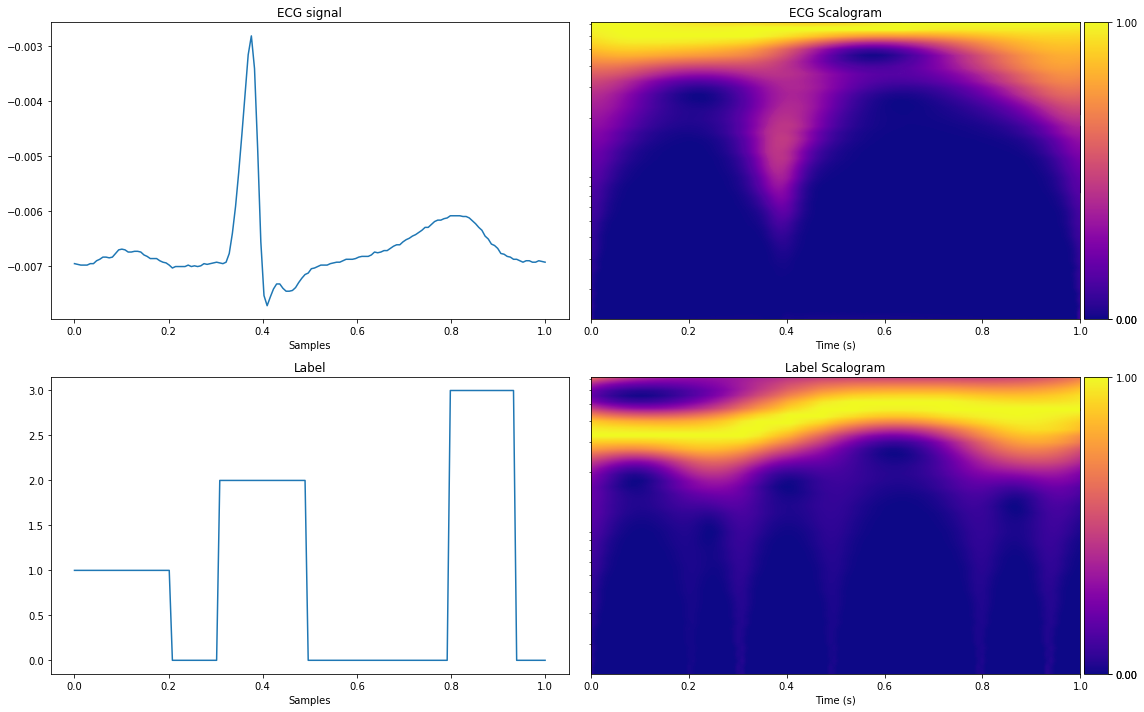

In [62]:
ind = np.random.randint(0,dat.shape[0],1).squeeze()
fig, ax = plt.subplots(2, 2, figsize=(16,10))
ax = ax.flatten()
ax[0].plot(t, dat[ind])
ax[0].set_title(r'ECG signal')
ax[0].set_xlabel('Samples')
plot_scalogram(power_ecg_torch.numpy()[ind].squeeze(), scales, t, ax=ax[1])
#ax[1].axhline(1.0 / random_frequencies[0], lw=1, color='k')
ax[1].set_title('ECG Scalogram')#.format(1.0/random_frequencies[0]))
ax[1].set_ylabel('')
ax[1].set_yticks([])

ax[2].plot(t, label[ind])
ax[2].set_title(r'Label')
ax[2].set_xlabel('Samples')
plot_scalogram(power_label_torch.numpy()[ind].squeeze(),scales, t, ax=ax[3])
#ax[1].axhline(1.0 / random_frequencies[0], lw=1, color='k')
ax[3].set_title('Label Scalogram')#.format(1.0/random_frequencies[0]))
ax[3].set_ylabel('')
ax[3].set_yticks([])

# plot_scalogram(power_torch1.numpy(), scales_torch1.numpy(), t, ax=ax[2])
# #ax[1].axhline(1.0 / random_frequencies[0], lw=1, color='k')
# ax[2].set_title('Scalogram dt=10/fs')#.format(1.0/random_frequencies[0]))
# ax[2].set_ylabel('')
# ax[2].set_yticks([])
plt.tight_layout()
plt.show()

In [10]:
tot_x = torch.stack([cwt_ecg_real,cwt_ecg_imag],1).squeeze(2)
tot_y = torch.stack([cwt_label_real,cwt_label_imag],1).squeeze(2)
# del cwt_ecg_real,cwt_ecg_imag,cwt_label_real,cwt_label_imag
tot_x.shape, tot_y.shape, cwt_ecg_real.shape, cwt_ecg_imag.shape

(torch.Size([1257, 2, 47, 150]),
 torch.Size([1257, 2, 47, 150]),
 torch.Size([1257, 1, 47, 150]),
 torch.Size([1257, 1, 47, 150]))

In [11]:
tot_dat = torch.cat([tot_x,tot_y],1)
tot_x.shape,tot_y.shape, tot_dat.shape, torch.stack([tot_x,tot_y],1).shape
del tot_x,tot_y

In [12]:
indices = torch.randperm(len(tot_dat))
valid_size = 257
train_size = 1000
train_indices = indices[:len(indices)-valid_size][:train_size or None]
test_indices = indices[len(indices)-valid_size:] #if valid_size else None


In [13]:
train_pow = tot_dat[train_indices]
train_x = train_pow[:,:2]
train_y = train_pow[:,2:]
test_pow = tot_dat[test_indices]
test_x = test_pow[:,:2]
test_y = test_pow[:,2:]

train_x.shape, train_y.shape,test_x.shape, test_y.shape
del tot_dat, train_pow,test_pow

In [42]:
# torch.cat([test_x,test_y],1).shape


(torch.Size([1000, 4, 47, 150]), torch.Size([257, 4, 47, 150]))

In [14]:
train_dat = torch.cat([train_x,train_y],1)
test_dat = torch.cat([test_x,test_y],1)
torch.save(train_dat, 'wavelet_dataset/train_dat_cwt.pt')
# torch.save(train_cwt, 'wavelet_dataset/train_cwt.pt')
torch.save(test_dat, 'wavelet_dataset/test_dat_cwt.pt')
# torch.save(test_cwt, 'wavelet_dataset/test_cwt.pt')


In [38]:
train_set = data_utils.TensorDataset(train_x, train_y)
train_set

In [57]:
np.save('wavelet_dataset/scales.npy',scales)